# Prediction Modeling

In [1]:
#data manipulation/visualization libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scikitplot as skplt
import seaborn as sns
import pickle 
import os

#model modules
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree

#data optimization modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


#metric modules
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, recall_score 
from sklearn.metrics import precision_score, confusion_matrix, precision_recall_curve

## Model 2 - Prediction Model

The final task for the project is to select and tune a model that can accuractly classify our Exited customers. Once tuned we can analyse its performance and its impact on the customer churn.

In [2]:
#load data

df = pd.read_csv("feature_engineered_df.csv")
df.head()

#split parameters from target
X, y = df.iloc[:,:16], df.iloc[:,-1]

#split test data from validation/data
X_val, X_test, y_val, y_test = train_test_split(X,y, test_size=.2, random_state=42, stratify=y)

#do one more split so we have portion of training data predict for validation
X_train, X_val_test, y_train, y_val_test = train_test_split(X_val, y_val, test_size=.1, random_state=21, stratify=y_val)

## Choosing a Model

In reviewing the data from EDA to Inferential Modeling, it is clear that the patterns within the data and subsequent thresholds show considerable overlap. As such, the simple, intutive algorithms of the prior notebook will be exchanged for ensemble tree methods such as:

* XGBoost - Extreme Gradient Boosting
* AdaBoost - Adaptive Boost
* RandomForest

In [3]:
# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(), 
               XGBClassifier(), 
               AdaBoostClassifier(), 
               RandomForestClassifier(),
               DecisionTreeClassifier(),
              ]

# Define a result table as a DataFrame
auc_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_val_test)[::,1]
    
    false_pr, true_pr, _ = roc_curve(y_val_test,  yproba)
    auc = roc_auc_score(y_val_test, yproba)
    
    auc_table = auc_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':false_pr, 
                                        'tpr':true_pr, 
                                        'auc':auc}, ignore_index=True)
    
    auc_table = auc_table.sort_values('auc', ascending=False)

# Set name of the classifiers as index labels
auc_table.set_index('classifiers', inplace=True)

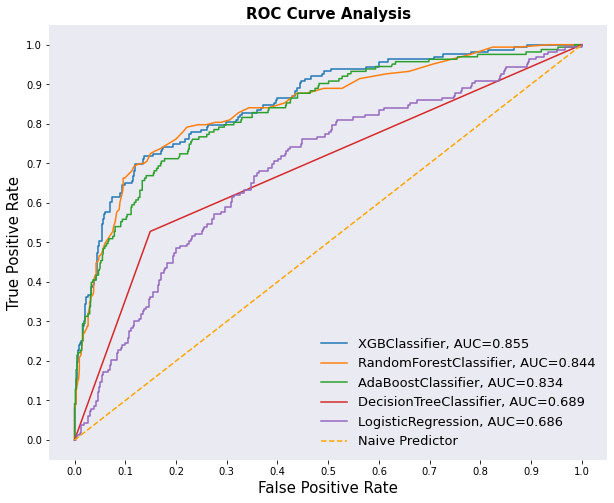

In [4]:
# Plot the figure
fig, ax = plt.subplots(1,1,figsize=(10,8))


for i in auc_table.index:
    plt.plot(auc_table.loc[i]['fpr'], 
             auc_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, auc_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--',label='Naive Predictor')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right',frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_facecolor('#EAEAF2')
plt.grid(b=False)
#plt.savefig('ROC2.png', format='png', transparent=True)
plt.show()

As expected the more complex models provided better ROC AUC scores, indicating they can allow us to maximize the TPR-FPR ratio for this data. That is paramount as TPR(Recall) will be massive influence on our model's final tuning.
### Hyperpermeter Optimization

Using all of the training(and validation) data, I'll tune the model for best hyperparameters via GridSearchCV

In [ ]:

xgb_params = {
                 'max_depth':[i for i in range(3,8)],
                 'min_child_weight':[i for i in range(1,6)],
                'gamma':[i/10.0 for i in range(0,5)],
                'colsample_bytree':[i/10.0 for i in range(0,11)],
                'subsample':[i/10.0 for i in range(0,11)]
}

    
xgb_grid = GridSearchCV(XGBClassifier(learning_rate =0.1, n_estimators=500, max_depth=5,
                        min_child_weight=1, gamma=0, objective='binary:logistic', scale_pos_weight=1),
                        param_grid = xgb_params, scoring='roc_auc',n_jobs=-1, cv=5, verbose=2)

xgb_grid.fit(X_val, y_val)

In [ ]:
# Save the optimized XGB model, fit to our training data
xgb_model = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=3,
    min_child_weight=4, gamma=.3, subsample=1.0, colsample_bytree=0.5,
    objective='binary:logistic', scale_pos_weight=1,seed=27).fit(X_val ,y_val)


# Pickle the model

dir_path = os.path.dirname(os.path.realpath('xgb_model.pickle'))

with open(str(dir_path) +'xgb_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_model, to_write)

In [5]:
dir_path = os.path.dirname(os.path.realpath('xgb_model.pickle'))

xgb_model = pickle.load(open(dir_path + '/pickled_models/xgb_model.pickle', 'rb'))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.48      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



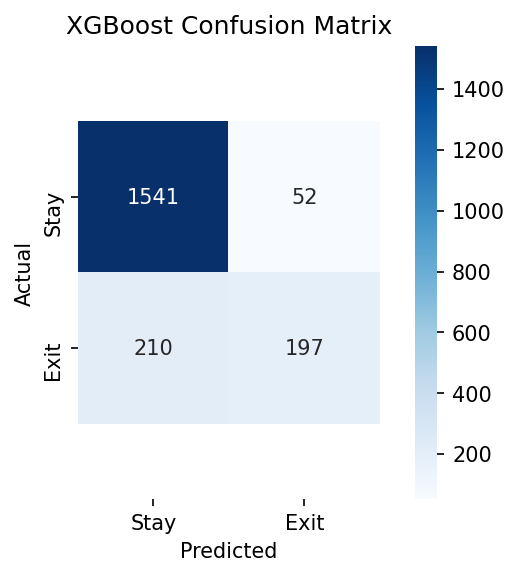

In [6]:
print(classification_report(y_test, xgb_model.predict(X_test)))
y_pred = xgb_model.predict(X_test)
xgb_confusion = confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
ax = sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Stay', 'Exit'],
           yticklabels=['Stay', 'Exit'])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix');
#plt.savefig('CM5.png', format='png', transparent=True);

### Baseline Analysis
The model shows marked perfomance increase over the models explored during the Inferential Modeling phase. Overall Accuracy is up to 87% so we are correctly identifying 87% of all tested observations.

Lets explore the target class (Exited) numbers:
- Precision = .79 - When the model classifies a record as Exited, it is correct 79% of the time
- Recall    = .48 - Of all the Exited observations tested, the model correctly detected 48% of them.

#### Interpreting for the business case.
When tuning the decision threshold we have to weigh the costs of a False Negative vs a False Positive. A basic assessment of those outcomes:
- False Negative - Customer is not identified as churn risk > Churns  Direct Cost: -91000&euro;
- False Positive - Customer is misidentified as churn risk > Wasted Intervention cost : TBD

Determining what the costs associated with intervention, whether that is an canned email campaign, deal on product, or human touch point the cost will likely hail in comparison to to the actual value of the accumulated False Negative.
To help inform this decision I created the threshold plot below that tracks the effect of different Thresholds have on the potential amount of Balance and Products that would be retained at each threshold level. Additionally I added a tracker of Precision and False Postive Rate as a proxy for Intervention costs.

In [11]:
y_pred_probs = xgb_model.predict_proba(X_test)[:,1]
y_pred_probs_series = pd.Series(y_pred_probs, index=y_test.index)

def get_churned_bal(X,y_test, y_pred):
    balance_total = 36708330.81
    total_products = 614
    threshold_bal_df = pd.DataFrame(columns=['Threshold', 'Retained Balance %', 'Retained Products %', 'FPR', 'Precision'])
    for threshold in np.arange(0.01,1.01,.01):
        threshold_bal = 0
        threshold_prod = 0 
        FP = 0
        TN = 0
        FN = 0
        TP = 0 
        for index, value in y_pred.iteritems():
            if value > threshold:
                if y_test.loc[index] == 0:
                    FP +=1
                else:
                    threshold_bal += X.loc[index]['Balance']
                    threshold_prod += X.loc[index]['NumOfProducts']
                    TP+=1
            else:
                if y_test.loc[index] == 0:
                    TN+=1
                else:
                    FN+=1
        bal_ratio = threshold_bal/balance_total
        FPR = FP/(FP+TN)
        precision = TP/(TP+FP+1)
        prod_ratio = threshold_prod/total_products
        threshold_bal_df = threshold_bal_df.append({'Threshold':threshold, 'Retained Balance %':bal_ratio,
                                                    'Retained Products %': prod_ratio, 'FPR':FPR, 'Precision':precision}, ignore_index=True)
    return threshold_bal_df


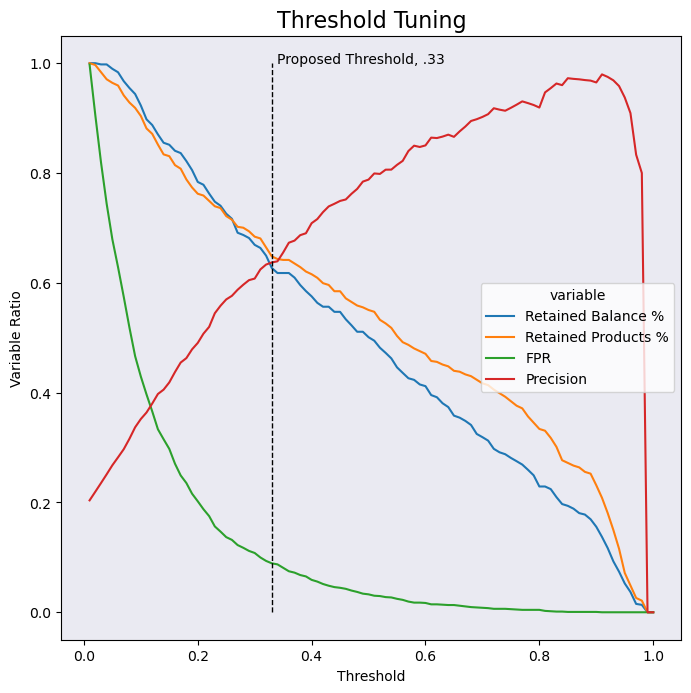

In [13]:
threshold_effects = get_churned_bal(X_test, y_test, y_pred_probs_series)

fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=100)
sns.lineplot(x='Threshold', y='value', hue='variable', data= pd.melt(threshold_effects, 'Threshold'), ax=ax)
ax.grid(False)
ax.set_facecolor('#EAEAF2')
ax.set_title('Threshold Tuning', fontdict={'fontsize':16,'fontweight':20})
ax.set_ylabel('Variable Ratio')
plt.plot([.33,.33],[0,1], 'k--', linewidth=1)
plt.text(.34,1, 'Proposed Threshold, .33');
#plt.savefig('threshold2.png', format='png', transparent=True)

So whereas the model initially was only classifiying >.5 as 'Exited', a more appropriate number would be in the neighborhood of .3-.35 as at those thresholds you are retaining most of the potentially Exited revenue and keeping a relatively narrow scope of Exited candidates insothat you are not burdening the business nor customer base 

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1593
           1       0.64      0.62      0.63       407

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.85      0.85      0.85      2000

Threshold              0.330000
Retained Balance %     0.627044
Retained Products %    0.648208
FPR                    0.089140
Precision              0.637056
Name: 32, dtype: float64


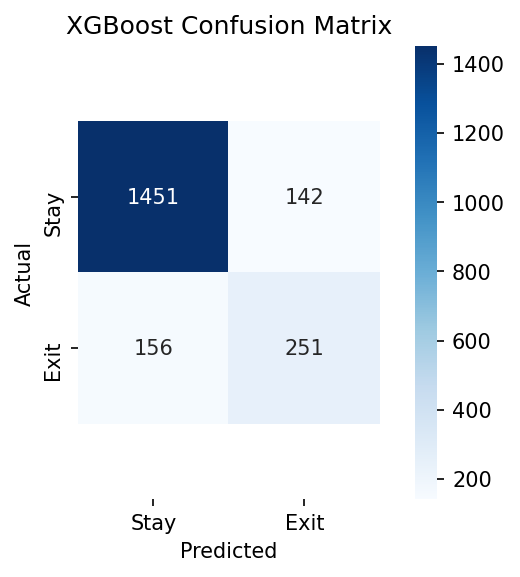

In [14]:
threshold = 0.33
y_pred = (xgb_model.predict_proba(X_test)[:, 1] > threshold).astype('float')
print(classification_report(y_test,y_pred))
print(threshold_effects.loc[32])
plt.figure(dpi=150)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Stay', 'Exit'],
           yticklabels=['Stay', 'Exit'])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix');
#plt.savefig('CM33.png', format='png', transparent=True);

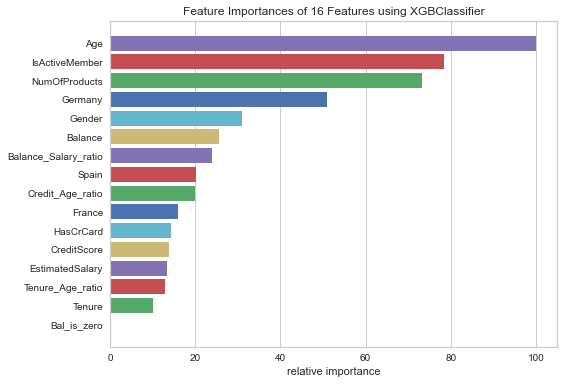

In [15]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.style import  set_palette

set_palette('sns_deep')

viz = FeatureImportances(xgb_model, labels=X_train.columns, relative=True)
viz.fit(X_val, y_val)
viz.show();

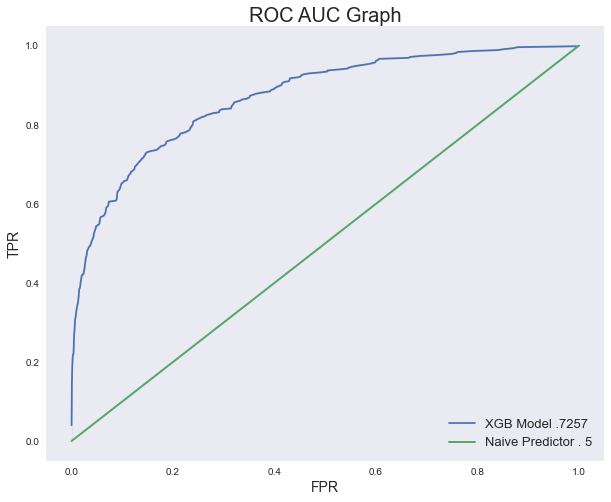

In [16]:
xgb_probs = xgb_model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, xgb_probs)

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax = sns.lineplot(x=fpr,y=tpr, label='XGB Model .7257')
plt.title('ROC AUC Graph',pad=4, fontsize=20)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.plot([0,1],[0,1], linewidth=2, label='Naive Predictor . 5')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.legend(prop={'size':13}, loc='lower right',frameon=False)

ax.set_facecolor('#EAEAF2')
plt.grid(b=False)
plt.show();

# Final Throughts

The final tuned model is a strong predictor in terms of classifiying our imbalance target parameter. I believe its tuned properly with the given information but undetermined variables such as 
- customer aquisition cost
- intervention cost
- intervention retention %

Would also effect the final stategy of the model. 

### Future Considerations
- Create models for different countries, as we see stark difference patterns in German customers vs Spanish/French customers
- Adding more data